In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
from google.colab import files
from scipy import stats
from scipy.stats import t, f

In [ ]:
drive.mount('/content/Drive/')

Drive already mounted at /content/Drive/; to attempt to forcibly remount, call drive.mount("/content/Drive/", force_remount=True).


# model 11 (solar data)

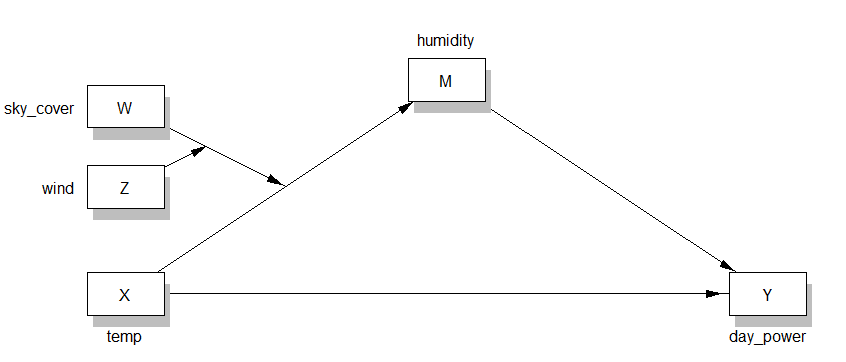

 X : temp(기온)  
M : humidity(습도)  
Y : day_power(태양광 발전량)  
W : sky_cover(운량)  
Z : wind(풍속)  



## * 퍼지화 
- X, M, Z : 일평균 데이터이므로 spread를 (다음날 - 현재) / 2 로 사용하여 삼각퍼지숫자 생성  
(마지막 data는 직전 spread 사용)  
- Y : crisp data
- W : 1~8 척도를 가지고 측정했으므로 설문조사와 같은 이유지만 조금 더 fuzzy하다고 생각하여 1 spread 사용하여 삼각퍼지숫자 생성

In [ ]:
data_18 = pd.read_csv('/content/Drive/MyDrive/논문/model_18.csv')
data_18.head()

,temp,wind,humidity,barometer,day_power,sky_cover
0,0.312052,0.234784,0.778769,0.638520,0.058824,2
1,0.369939,0.412924,0.725910,0.424439,0.058824,3
2,0.352761,0.572187,0.709644,0.296313,0.058824,5
3,0.348520,0.334605,0.751113,0.118489,0.029412,3
4,0.348466,0.313384,0.735478,0.160241,0.029412,6


In [ ]:
len(data_18)

1332

* temp, wind, humidity 퍼지화

In [ ]:
data = data_18['temp']
X_fuz = []
for i in range(len(data)-1):
  spread = np.abs(data[i] - data[i+1]) / 2
  X_fuz.append([data[i] - spread, data[i], data[i] + spread])
X_fuz.append([data[len(data)-1] - spread, data[len(data)-1], data[len(data)-1] + spread])

In [ ]:
X_fuz = np.array(X_fuz)
X_fuz

array([[0.28310838, 0.31205181, 0.34099523],
       [0.36134969, 0.36993865, 0.37852761],
       [0.35064017, 0.35276074, 0.3548813 ],
       ...,
       [0.22226483, 0.25710634, 0.29194785],
       [0.30696575, 0.32678937, 0.34661299],
       [0.26731851, 0.28714213, 0.30696575]])

In [ ]:
data = data_18['wind']
Z_fuz = []
for i in range(len(data)-1):
  spread = np.abs(data[i] - data[i+1]) / 2
  Z_fuz.append([data[i] - spread, data[i], data[i] + spread])
Z_fuz.append([data[len(data)-1] - spread, data[len(data)-1], data[len(data)-1] + spread])

In [ ]:
Z_fuz = np.array(Z_fuz)
Z_fuz

array([[0.14571496, 0.23478449, 0.32385403],
       [0.33329186, 0.41292356, 0.49255527],
       [0.4533958 , 0.57218697, 0.69097814],
       ...,
       [0.00877193, 0.10331384, 0.19785575],
       [0.26250812, 0.29239766, 0.3222872 ],
       [0.20272904, 0.23261858, 0.26250812]])

In [ ]:
data = data_18['humidity']
M_fuz = []
for i in range(len(data)-1):
  spread = np.abs(data[i] - data[i+1]) / 2
  M_fuz.append([data[i] - spread, data[i], data[i] + spread])
M_fuz.append([data[len(data)-1] - spread, data[len(data)-1], data[len(data)-1] + spread])

In [ ]:
M_fuz = np.array(M_fuz)
M_fuz

array([[0.75233957, 0.77876915, 0.80519874],
       [0.71777698, 0.72590998, 0.73404298],
       [0.68890934, 0.70964398, 0.73037862],
       ...,
       [0.78451541, 0.80918683, 0.83385826],
       [0.72049462, 0.75984399, 0.79919335],
       [0.6417959 , 0.68114526, 0.72049462]])

* sky cover 퍼지화

In [ ]:
W_fuz = np.array([data_18['sky_cover'] - 1, data_18['sky_cover'], data_18['sky_cover'] + 1]).T
W_fuz

array([[1, 2, 3],
       [2, 3, 4],
       [4, 5, 6],
       ...,
       [1, 2, 3],
       [6, 7, 8],
       [3, 4, 5]])

In [ ]:
row, col = W_fuz.shape

In [ ]:
for i in range(row):    # 1~8 이므로 1보다 작거나 8보다 큰 부분 수정
  if W_fuz[i][0] < 1:
    W_fuz[i][0] = 1
  elif W_fuz[i][2] >8:
    W_fuz[i][2] = 8

* day_power crisp

In [ ]:
Y_fuz = np.array([data_18['day_power'], data_18['day_power'], data_18['day_power']]).T
Y_fuz

array([[0.05882353, 0.05882353, 0.05882353],
       [0.05882353, 0.05882353, 0.05882353],
       [0.05882353, 0.05882353, 0.05882353],
       ...,
       [0.08823529, 0.08823529, 0.08823529],
       [0.        , 0.        , 0.        ],
       [0.17647059, 0.17647059, 0.17647059]])

In [ ]:
Y_fuz.shape

(1332, 3)

In [ ]:
XW_fuz = X_fuz * W_fuz
XZ_fuz = X_fuz * Z_fuz
WZ_fuz = W_fuz * Z_fuz
XWZ_fuz = X_fuz * W_fuz * Z_fuz

In [ ]:
one = np.ones((1332,3))

## Neural Net 입력을 위해 삼각퍼지수 쪼개기

In [ ]:
X_l = []
X_m = []
X_r = []

M_l = []
M_m = []
M_r = []

Y_l = []
Y_m = []
Y_r = []

W_l = []
W_m = []
W_r = []

Z_l = []
Z_m = []
Z_r = []

XW_l = []
XW_m = []
XW_r = []

XZ_l = []
XZ_m = []
XZ_r = []

WZ_l = []
WZ_m = []
WZ_r = []

XWZ_l = []
XWZ_m = []
XWZ_r = []

In [ ]:
for i in range(len(data_18)):
  X_l.append(X_fuz[i][0])
  X_m.append(X_fuz[i][1])
  X_r.append(X_fuz[i][2])

In [ ]:
for i in range(len(data_18)):
  M_l.append(M_fuz[i][0])
  M_m.append(M_fuz[i][1])
  M_r.append(M_fuz[i][2])

for i in range(len(data_18)):
  Y_l.append(Y_fuz[i][0])
  Y_m.append(Y_fuz[i][1])
  Y_r.append(Y_fuz[i][2])

for i in range(len(data_18)):
  W_l.append(W_fuz[i][0])
  W_m.append(W_fuz[i][1])
  W_r.append(W_fuz[i][2])

for i in range(len(data_18)):
  Z_l.append(Z_fuz[i][0])
  Z_m.append(Z_fuz[i][1])
  Z_r.append(Z_fuz[i][2])

for i in range(len(data_18)):
  XW_l.append(XW_fuz[i][0])
  XW_m.append(XW_fuz[i][1])
  XW_r.append(XW_fuz[i][2])

for i in range(len(data_18)):
  XZ_l.append(XZ_fuz[i][0])
  XZ_m.append(XZ_fuz[i][1])
  XZ_r.append(XZ_fuz[i][2])

for i in range(len(data_18)):
  WZ_l.append(WZ_fuz[i][0])
  WZ_m.append(WZ_fuz[i][1])
  WZ_r.append(WZ_fuz[i][2])

for i in range(len(data_18)):
  XWZ_l.append(XWZ_fuz[i][0])
  XWZ_m.append(XWZ_fuz[i][1])
  XWZ_r.append(XWZ_fuz[i][2]) 

## DL 회귀

* 매 시행마다, 동일한 결과 도출하기 위해 torch, numpy, random의 seed 설정

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
random_seed = 2
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [ ]:
ep = 800 # epoch 설정

### 1) SGD이용

* M_l 

In [ ]:
x_train = torch.FloatTensor([X_l, W_l, Z_l, XW_l, XZ_l, WZ_l, XWZ_l])

In [ ]:
x_train = x_train.T

In [ ]:
x_train.shape

torch.Size([1332, 7])

In [ ]:
x_train

tensor([[2.8311e-01, 1.0000e+00, 1.4571e-01,  ..., 4.1253e-02, 1.4571e-01,
         4.1253e-02],
        [3.6135e-01, 2.0000e+00, 3.3329e-01,  ..., 1.2043e-01, 6.6658e-01,
         2.4087e-01],
        [3.5064e-01, 4.0000e+00, 4.5340e-01,  ..., 1.5898e-01, 1.8136e+00,
         6.3592e-01],
        ...,
        [2.2226e-01, 1.0000e+00, 8.7719e-03,  ..., 1.9497e-03, 8.7719e-03,
         1.9497e-03],
        [3.0697e-01, 6.0000e+00, 2.6251e-01,  ..., 8.0581e-02, 1.5750e+00,
         4.8349e-01],
        [2.6732e-01, 3.0000e+00, 2.0273e-01,  ..., 5.4193e-02, 6.0819e-01,
         1.6258e-01]])

In [ ]:
y_train = torch.FloatTensor([M_l]) # M
y_train = y_train.T

In [ ]:
y_train.shape

torch.Size([1332, 1])

In [ ]:
Weight_l = torch.zeros((7,1), requires_grad=True)
Bias_l = torch.zeros(1, requires_grad=True)

In [ ]:
# optimizer 설정
optimizer = optim.SGD([Weight_l, Bias_l], lr=0.01)  # SGD, lr - 0.01고정

nb_epochs = ep  # epoch 

for epoch in range(nb_epochs + 1):
    
    # H(X) 계산
    hypothesis = x_train.matmul(Weight_l) + Bias_l
    
    # cost 계산
    cost = torch.mean((hypothesis - y_train) ** 2)
    
    # Backpropagation
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    print('Epoch {:4d}/{} hypothesis: {} Cost: {:.6f}'.format(
        epoch, nb_epochs, hypothesis.squeeze().detach(), cost.item()
    ))

Epoch    0/800 hypothesis: tensor([0., 0., 0.,  ..., 0., 0., 0.]) Cost: 0.360014
Epoch    1/800 hypothesis: tensor([0.0582, 0.1107, 0.2118,  ..., 0.0550, 0.2925, 0.1488]) Cost: 0.190367
Epoch    2/800 hypothesis: tensor([0.0973, 0.1847, 0.3528,  ..., 0.0920, 0.4872, 0.2481]) Cost: 0.115006
Epoch    3/800 hypothesis: tensor([0.1237, 0.2342, 0.4467,  ..., 0.1170, 0.6170, 0.3146]) Cost: 0.081460
Epoch    4/800 hypothesis: tensor([0.1416, 0.2674, 0.5092,  ..., 0.1341, 0.7034, 0.3591]) Cost: 0.066456
Epoch    5/800 hypothesis: tensor([0.1539, 0.2897, 0.5509,  ..., 0.1458, 0.7610, 0.3890]) Cost: 0.059677
Epoch    6/800 hypothesis: tensor([0.1625, 0.3048, 0.5786,  ..., 0.1540, 0.7993, 0.4091]) Cost: 0.056547
Epoch    7/800 hypothesis: tensor([0.1685, 0.3151, 0.5970,  ..., 0.1598, 0.8249, 0.4228]) Cost: 0.055035
Epoch    8/800 hypothesis: tensor([0.1729, 0.3221, 0.6093,  ..., 0.1641, 0.8419, 0.4322]) Cost: 0.054242
Epoch    9/800 hypothesis: tensor([0.1761, 0.3270, 0.6174,  ..., 0.1673, 0.8533

In [ ]:
print(Weight_l)
print(Bias_l)

tensor([[ 0.0746],
        [ 0.1032],
        [ 0.0646],
        [-0.1242],
        [ 0.0187],
        [-0.0242],
        [-0.0256]], requires_grad=True)
tensor([0.3977], requires_grad=True)


* M_m

In [ ]:
x_train = torch.FloatTensor([X_m, W_m, Z_m, XW_m, XZ_m, WZ_m, XWZ_m])

In [ ]:
x_train = x_train.T

In [ ]:
x_train.shape

torch.Size([1332, 7])

In [ ]:
y_train = torch.FloatTensor([M_m]) # M
y_train = y_train.T

In [ ]:
y_train.shape

torch.Size([1332, 1])

In [ ]:
Weight_m = torch.zeros((7,1), requires_grad=True)
Bias_m = torch.zeros(1, requires_grad=True)

In [ ]:
# optimizer 설정
optimizer = optim.SGD([Weight_m, Bias_m], lr=0.01)  # SGD, lr - 0.01고정

nb_epochs = ep  # epoch 

for epoch in range(nb_epochs + 1):
    
    # H(X) 계산
    hypothesis = x_train.matmul(Weight_m) + Bias_m
    
    # cost 계산
    cost = torch.mean((hypothesis - y_train) ** 2)
    
    # Backpropagation
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    print('Epoch {:4d}/{} hypothesis: {} Cost: {:.6f}'.format(
        epoch, nb_epochs, hypothesis.squeeze().detach(), cost.item()
    ))

Epoch    0/800 hypothesis: tensor([0., 0., 0.,  ..., 0., 0., 0.]) Cost: 0.411720
Epoch    1/800 hypothesis: tensor([0.1469, 0.2287, 0.3835,  ..., 0.1383, 0.4868, 0.2756]) Cost: 0.120453
Epoch    2/800 hypothesis: tensor([0.2128, 0.3307, 0.5540,  ..., 0.2005, 0.7037, 0.3988]) Cost: 0.062694
Epoch    3/800 hypothesis: tensor([0.2427, 0.3764, 0.6298,  ..., 0.2289, 0.8007, 0.4543]) Cost: 0.051069
Epoch    4/800 hypothesis: tensor([0.2565, 0.3970, 0.6636,  ..., 0.2422, 0.8444, 0.4797]) Cost: 0.048562
Epoch    5/800 hypothesis: tensor([0.2632, 0.4066, 0.6787,  ..., 0.2488, 0.8644, 0.4917]) Cost: 0.047859
Epoch    6/800 hypothesis: tensor([0.2668, 0.4111, 0.6855,  ..., 0.2524, 0.8738, 0.4977]) Cost: 0.047516
Epoch    7/800 hypothesis: tensor([0.2689, 0.4135, 0.6885,  ..., 0.2548, 0.8786, 0.5011]) Cost: 0.047247
Epoch    8/800 hypothesis: tensor([0.2704, 0.4149, 0.6899,  ..., 0.2565, 0.8812, 0.5033]) Cost: 0.046996
Epoch    9/800 hypothesis: tensor([0.2717, 0.4158, 0.6906,  ..., 0.2579, 0.8830

In [ ]:
print(Weight_m)
print(Bias_m)

tensor([[ 0.0882],
        [ 0.1054],
        [ 0.0799],
        [-0.1029],
        [ 0.0281],
        [-0.0244],
        [-0.0207]], requires_grad=True)
tensor([0.3524], requires_grad=True)


* M_r

In [ ]:
x_train = torch.FloatTensor([X_r, W_r, Z_r, XW_r, XZ_r, WZ_r, XWZ_r])

In [ ]:
x_train = x_train.T

In [ ]:
x_train.shape

torch.Size([1332, 7])

In [ ]:
x_train

tensor([[0.3410, 3.0000, 0.3239,  ..., 0.1104, 0.9716, 0.3313],
        [0.3785, 4.0000, 0.4926,  ..., 0.1864, 1.9702, 0.7458],
        [0.3549, 6.0000, 0.6910,  ..., 0.2452, 4.1459, 1.4713],
        ...,
        [0.2919, 3.0000, 0.1979,  ..., 0.0578, 0.5936, 0.1733],
        [0.3466, 8.0000, 0.3223,  ..., 0.1117, 2.5783, 0.8937],
        [0.3070, 5.0000, 0.2625,  ..., 0.0806, 1.3125, 0.4029]])

In [ ]:
y_train = torch.FloatTensor([M_r]) # M
y_train = y_train.T

In [ ]:
y_train.shape

torch.Size([1332, 1])

In [ ]:
Weight_r = torch.zeros((7,1), requires_grad=True)
Bias_r = torch.zeros(1, requires_grad=True)

In [ ]:
# optimizer 설정
optimizer = optim.SGD([Weight_r, Bias_r], lr=0.01)  # SGD, lr - 0.01고정

nb_epochs = ep  # epoch 

for epoch in range(nb_epochs + 1):
    
    # H(X) 계산
    hypothesis = x_train.matmul(Weight_r) + Bias_r
    
    # cost 계산
    cost = torch.mean((hypothesis - y_train) ** 2)
    
    # Backpropagation
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    print('Epoch {:4d}/{} hypothesis: {} Cost: {:.6f}'.format(
        epoch, nb_epochs, hypothesis.squeeze().detach(), cost.item()
    ))

Epoch    0/800 hypothesis: tensor([0., 0., 0.,  ..., 0., 0., 0.]) Cost: 0.470363
Epoch    1/800 hypothesis: tensor([0.2946, 0.4146, 0.6437,  ..., 0.2767, 0.7580, 0.4631]) Cost: 0.054646
Epoch    2/800 hypothesis: tensor([0.3367, 0.4730, 0.7334,  ..., 0.3168, 0.8654, 0.5294]) Cost: 0.046203
Epoch    3/800 hypothesis: tensor([0.3437, 0.4817, 0.7460,  ..., 0.3239, 0.8823, 0.5406]) Cost: 0.045649
Epoch    4/800 hypothesis: tensor([0.3458, 0.4836, 0.7478,  ..., 0.3264, 0.8865, 0.5440]) Cost: 0.045258
Epoch    5/800 hypothesis: tensor([0.3472, 0.4845, 0.7482,  ..., 0.3283, 0.8890, 0.5463]) Cost: 0.044881
Epoch    6/800 hypothesis: tensor([0.3485, 0.4853, 0.7484,  ..., 0.3301, 0.8912, 0.5485]) Cost: 0.044515
Epoch    7/800 hypothesis: tensor([0.3497, 0.4860, 0.7485,  ..., 0.3318, 0.8933, 0.5506]) Cost: 0.044158
Epoch    8/800 hypothesis: tensor([0.3510, 0.4867, 0.7486,  ..., 0.3335, 0.8954, 0.5526]) Cost: 0.043812
Epoch    9/800 hypothesis: tensor([0.3522, 0.4874, 0.7488,  ..., 0.3352, 0.8975

In [ ]:
print(Weight_r)
print(Bias_r)

tensor([[ 0.0892],
        [ 0.1060],
        [ 0.0875],
        [-0.0843],
        [ 0.0354],
        [-0.0214],
        [-0.0115]], requires_grad=True)
tensor([0.2971], requires_grad=True)


In [ ]:
print(Weight_l)
print(Weight_m)
print(Weight_r)

tensor([[ 0.0746],
        [ 0.1032],
        [ 0.0646],
        [-0.1242],
        [ 0.0187],
        [-0.0242],
        [-0.0256]], requires_grad=True)
tensor([[ 0.0882],
        [ 0.1054],
        [ 0.0799],
        [-0.1029],
        [ 0.0281],
        [-0.0244],
        [-0.0207]], requires_grad=True)
tensor([[ 0.0892],
        [ 0.1060],
        [ 0.0875],
        [-0.0843],
        [ 0.0354],
        [-0.0214],
        [-0.0115]], requires_grad=True)


#### * M

In [ ]:
(Weight_l + Weight_m + Weight_r)/ 3

tensor([[ 0.0840],
        [ 0.1049],
        [ 0.0773],
        [-0.1038],
        [ 0.0274],
        [-0.0233],
        [-0.0192]], grad_fn=<DivBackward0>)

In [ ]:
(Bias_l + Bias_m + Bias_r)/ 3

tensor([0.3491], grad_fn=<DivBackward0>)

* Y_l 

In [ ]:
x_train = torch.FloatTensor([X_l, M_l])

In [ ]:
x_train = x_train.T

In [ ]:
x_train.shape

torch.Size([1332, 2])

In [ ]:
y_train = torch.FloatTensor([Y_l]) # Y
y_train = y_train.T

In [ ]:
y_train.shape

torch.Size([1332, 1])

In [ ]:
Weight_l = torch.zeros((2,1), requires_grad=True)  # 가중치 초기화
Bias_l = torch.zeros(1, requires_grad=True)

In [ ]:
# optimizer 설정
optimizer = optim.SGD([Weight_l, Bias_l], lr=0.01)  # SGD, lr - 0.01고정

nb_epochs = ep  # epoch 

for epoch in range(nb_epochs + 1):
    
    # H(X) 계산
    hypothesis = x_train.matmul(Weight_l) + Bias_l
    
    # cost 계산
    cost = torch.mean((hypothesis - y_train) ** 2)
    
    # Backpropagation
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    print('Epoch {:4d}/{} hypothesis: {} Cost: {:.6f}'.format(
        epoch, nb_epochs, hypothesis.squeeze().detach(), cost.item()
    ))

Epoch    0/800 hypothesis: tensor([0., 0., 0.,  ..., 0., 0., 0.]) Cost: 0.172231
Epoch    1/800 hypothesis: tensor([0.0103, 0.0105, 0.0104,  ..., 0.0102, 0.0103, 0.0099]) Cost: 0.165255
Epoch    2/800 hypothesis: tensor([0.0203, 0.0207, 0.0204,  ..., 0.0201, 0.0203, 0.0195]) Cost: 0.158703
Epoch    3/800 hypothesis: tensor([0.0300, 0.0305, 0.0301,  ..., 0.0296, 0.0299, 0.0287]) Cost: 0.152550
Epoch    4/800 hypothesis: tensor([0.0393, 0.0400, 0.0395,  ..., 0.0389, 0.0393, 0.0377]) Cost: 0.146769
Epoch    5/800 hypothesis: tensor([0.0484, 0.0493, 0.0486,  ..., 0.0478, 0.0483, 0.0464]) Cost: 0.141340
Epoch    6/800 hypothesis: tensor([0.0572, 0.0582, 0.0575,  ..., 0.0565, 0.0571, 0.0548]) Cost: 0.136239
Epoch    7/800 hypothesis: tensor([0.0657, 0.0669, 0.0660,  ..., 0.0649, 0.0656, 0.0630]) Cost: 0.131448
Epoch    8/800 hypothesis: tensor([0.0739, 0.0752, 0.0743,  ..., 0.0730, 0.0738, 0.0709]) Cost: 0.126946
Epoch    9/800 hypothesis: tensor([0.0819, 0.0834, 0.0823,  ..., 0.0808, 0.0818

In [ ]:
print(Weight_l)
print(Bias_l)

tensor([[ 0.4240],
        [-0.2171]], requires_grad=True)
tensor([0.2611], requires_grad=True)


* Y_m

In [ ]:
x_train = torch.FloatTensor([X_m,M_m])

In [ ]:
x_train = x_train.T

In [ ]:
x_train.shape

torch.Size([1332, 2])

In [ ]:
y_train = torch.FloatTensor([Y_m]) # Y
y_train = y_train.T

In [ ]:
y_train.shape

torch.Size([1332, 1])

In [ ]:
Weight_m = torch.zeros((2,1), requires_grad=True)  # 가중치 초기화
Bias_m = torch.zeros(1, requires_grad=True)

In [ ]:
# optimizer 설정
optimizer = optim.SGD([Weight_m, Bias_m], lr=0.01)  # SGD, lr - 0.01고정

nb_epochs = ep  # epoch 

for epoch in range(nb_epochs + 1):
    
    # H(X) 계산
    hypothesis = x_train.matmul(Weight_m) + Bias_m
    
    # cost 계산
    cost = torch.mean((hypothesis - y_train) ** 2)
    
    # Backpropagation
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    print('Epoch {:4d}/{} hypothesis: {} Cost: {:.6f}'.format(
        epoch, nb_epochs, hypothesis.squeeze().detach(), cost.item()
    ))

Epoch    0/800 hypothesis: tensor([0., 0., 0.,  ..., 0., 0., 0.]) Cost: 0.172231
Epoch    1/800 hypothesis: tensor([0.0108, 0.0108, 0.0107,  ..., 0.0107, 0.0108, 0.0104]) Cost: 0.164924
Epoch    2/800 hypothesis: tensor([0.0213, 0.0213, 0.0211,  ..., 0.0211, 0.0212, 0.0204]) Cost: 0.158083
Epoch    3/800 hypothesis: tensor([0.0314, 0.0315, 0.0311,  ..., 0.0311, 0.0313, 0.0301]) Cost: 0.151679
Epoch    4/800 hypothesis: tensor([0.0411, 0.0413, 0.0408,  ..., 0.0407, 0.0411, 0.0394]) Cost: 0.145682
Epoch    5/800 hypothesis: tensor([0.0506, 0.0508, 0.0502,  ..., 0.0501, 0.0505, 0.0485]) Cost: 0.140066
Epoch    6/800 hypothesis: tensor([0.0597, 0.0599, 0.0592,  ..., 0.0591, 0.0596, 0.0572]) Cost: 0.134808
Epoch    7/800 hypothesis: tensor([0.0685, 0.0688, 0.0680,  ..., 0.0678, 0.0685, 0.0657]) Cost: 0.129884
Epoch    8/800 hypothesis: tensor([0.0770, 0.0773, 0.0764,  ..., 0.0762, 0.0770, 0.0738]) Cost: 0.125273
Epoch    9/800 hypothesis: tensor([0.0853, 0.0856, 0.0846,  ..., 0.0844, 0.0852

In [ ]:
print(Weight_m)
print(Bias_m)

tensor([[ 0.4278],
        [-0.2073]], requires_grad=True)
tensor([0.2527], requires_grad=True)


* Y_r

In [ ]:
x_train = torch.FloatTensor([X_r, M_r])

In [ ]:
x_train = x_train.T

In [ ]:
x_train.shape

torch.Size([1332, 2])

In [ ]:
y_train = torch.FloatTensor([Y_r]) # Y
y_train = y_train.T

In [ ]:
y_train.shape

torch.Size([1332, 1])

In [ ]:
Weight_r = torch.zeros((2,1), requires_grad=True)  # 가중치 초기화
Bias_r = torch.zeros(1, requires_grad=True)

In [ ]:
# optimizer 설정
optimizer = optim.SGD([Weight_r, Bias_r], lr=0.01)  # SGD, lr - 0.01고정

nb_epochs = ep  # epoch 

for epoch in range(nb_epochs + 1):
    
    # H(X) 계산
    hypothesis = x_train.matmul(Weight_r) + Bias_r
    
    # cost 계산
    cost = torch.mean((hypothesis - y_train) ** 2)
    
    # Backpropagation
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    print('Epoch {:4d}/{} hypothesis: {} Cost: {:.6f}'.format(
        epoch, nb_epochs, hypothesis.squeeze().detach(), cost.item()
    ))

Epoch    0/800 hypothesis: tensor([0., 0., 0.,  ..., 0., 0., 0.]) Cost: 0.172231
Epoch    1/800 hypothesis: tensor([0.0113, 0.0112, 0.0111,  ..., 0.0112, 0.0113, 0.0109]) Cost: 0.164570
Epoch    2/800 hypothesis: tensor([0.0223, 0.0220, 0.0218,  ..., 0.0221, 0.0223, 0.0213]) Cost: 0.157421
Epoch    3/800 hypothesis: tensor([0.0328, 0.0325, 0.0321,  ..., 0.0326, 0.0328, 0.0314]) Cost: 0.150751
Epoch    4/800 hypothesis: tensor([0.0430, 0.0425, 0.0421,  ..., 0.0427, 0.0430, 0.0412]) Cost: 0.144528
Epoch    5/800 hypothesis: tensor([0.0528, 0.0522, 0.0517,  ..., 0.0524, 0.0528, 0.0506]) Cost: 0.138720
Epoch    6/800 hypothesis: tensor([0.0623, 0.0616, 0.0610,  ..., 0.0618, 0.0623, 0.0597]) Cost: 0.133301
Epoch    7/800 hypothesis: tensor([0.0715, 0.0707, 0.0700,  ..., 0.0709, 0.0715, 0.0685]) Cost: 0.128243
Epoch    8/800 hypothesis: tensor([0.0803, 0.0794, 0.0786,  ..., 0.0796, 0.0803, 0.0770]) Cost: 0.123523
Epoch    9/800 hypothesis: tensor([0.0888, 0.0879, 0.0870,  ..., 0.0881, 0.0888

In [ ]:
print(Weight_r)
print(Bias_r)

tensor([[ 0.4286],
        [-0.1962]], requires_grad=True)
tensor([0.2441], requires_grad=True)


In [ ]:
print(Weight_l)
print(Weight_m)
print(Weight_r)

tensor([[ 0.4240],
        [-0.2171]], requires_grad=True)
tensor([[ 0.4278],
        [-0.2073]], requires_grad=True)
tensor([[ 0.4286],
        [-0.1962]], requires_grad=True)


#### * Y

In [ ]:
(Weight_l + Weight_m + Weight_r)/ 3

tensor([[ 0.4268],
        [-0.2069]], grad_fn=<DivBackward0>)

In [ ]:
(Bias_l + Bias_m + Bias_r)/ 3

tensor([0.2526], grad_fn=<DivBackward0>)

### * MSE & R2

In [ ]:
Y_fuz_hat = 0.2526 + 0.4268*X_fuz - 0.2069*M_fuz

In [ ]:
TSS = ((Y_fuz-Y_fuz.mean())**2).sum(axis=1).sum()
SSR = ((Y_fuz_hat-Y_fuz.mean())**2).sum(axis=1).sum()
SSE = ((Y_fuz-Y_fuz_hat)**2).sum(axis=1).sum()

In [ ]:
R2 = 1 - SSE / TSS
print(R2)

0.4649398056352392


In [ ]:
mse = ((Y_fuz - Y_fuz_hat) ** 2).sum(axis=1).sum() / 1329
print(mse)

0.09341811533138646


----

### 2) Momentum

* M_l 

In [ ]:
x_train = torch.FloatTensor([X_l, W_l, Z_l, XW_l, XZ_l, WZ_l, XWZ_l])

In [ ]:
x_train = x_train.T

In [ ]:
x_train.shape

torch.Size([1332, 7])

In [ ]:
y_train = torch.FloatTensor([M_l]) # M
y_train = y_train.T

In [ ]:
y_train.shape

torch.Size([1332, 1])

In [ ]:
Weight_l = torch.zeros((7,1), requires_grad=True)  # 가중치 초기화
Bias_l = torch.zeros(1, requires_grad=True)

In [ ]:
# optimizer 설정
optimizer = optim.SGD([Weight_l, Bias_l], lr=0.01, momentum=0.9)  # Momentum, lr - 0.01고정

nb_epochs = ep  # epoch 

for epoch in range(nb_epochs + 1):
    
    # H(X) 계산
    hypothesis = x_train.matmul(Weight_l) + Bias_l
    
    # cost 계산
    cost = torch.mean((hypothesis - y_train) ** 2)
    
    # Backpropagation
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    print('Epoch {:4d}/{} hypothesis: {} Cost: {:.6f}'.format(
        epoch, nb_epochs, hypothesis.squeeze().detach(), cost.item()
    ))

Epoch    0/800 hypothesis: tensor([0., 0., 0.,  ..., 0., 0., 0.]) Cost: 0.360014
Epoch    1/800 hypothesis: tensor([0.0582, 0.1107, 0.2118,  ..., 0.0550, 0.2925, 0.1488]) Cost: 0.190367
Epoch    2/800 hypothesis: tensor([0.1497, 0.2844, 0.5434,  ..., 0.1415, 0.7505, 0.3820]) Cost: 0.061141
Epoch    3/800 hypothesis: tensor([0.2412, 0.4571, 0.8721,  ..., 0.2282, 1.2045, 0.6139]) Cost: 0.097285
Epoch    4/800 hypothesis: tensor([0.3032, 0.5718, 1.0883,  ..., 0.2871, 1.5033, 0.7678]) Cost: 0.209973
Epoch    5/800 hypothesis: tensor([0.3191, 0.5968, 1.1310,  ..., 0.3027, 1.5627, 0.8010]) Cost: 0.239939
Epoch    6/800 hypothesis: tensor([0.2896, 0.5336, 1.0033,  ..., 0.2756, 1.3868, 0.7156]) Cost: 0.155147
Epoch    7/800 hypothesis: tensor([0.2308, 0.4132, 0.7647,  ..., 0.2209, 1.0580, 0.5532]) Cost: 0.063608
Epoch    8/800 hypothesis: tensor([0.1671, 0.2827, 0.5061,  ..., 0.1616, 0.7015, 0.3771]) Cost: 0.061612
Epoch    9/800 hypothesis: tensor([0.1221, 0.1879, 0.3158,  ..., 0.1200, 0.4393

In [ ]:
print(Weight_l)
print(Bias_l)

tensor([[-0.1498],
        [ 0.0745],
        [ 0.0046],
        [-0.0983],
        [ 0.0164],
        [-0.0605],
        [ 0.1076]], requires_grad=True)
tensor([0.5590], requires_grad=True)


* M_m

In [ ]:
x_train = torch.FloatTensor([X_m, W_m, Z_m, XW_m, XZ_m, WZ_m, XWZ_m])

In [ ]:
x_train = x_train.T

In [ ]:
x_train.shape

torch.Size([1332, 7])

In [ ]:
y_train = torch.FloatTensor([M_m]) # M
y_train = y_train.T

In [ ]:
y_train.shape

torch.Size([1332, 1])

In [ ]:
Weight_m = torch.zeros((7,1), requires_grad=True)  # 가중치 초기화
Bias_m = torch.zeros(1, requires_grad=True)

In [ ]:
# optimizer 설정
optimizer = optim.SGD([Weight_m, Bias_m], lr=0.01, momentum=0.9)  # Momentum, lr - 0.01고정

nb_epochs = ep  # epoch 

for epoch in range(nb_epochs + 1):
    
    # H(X) 계산
    hypothesis = x_train.matmul(Weight_m) + Bias_m
    
    # cost 계산
    cost = torch.mean((hypothesis - y_train) ** 2)
    
    # Backpropagation
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    print('Epoch {:4d}/{} hypothesis: {} Cost: {:.6f}'.format(
        epoch, nb_epochs, hypothesis.squeeze().detach(), cost.item()
    ))

Epoch    0/800 hypothesis: tensor([0., 0., 0.,  ..., 0., 0., 0.]) Cost: 0.411720
Epoch    1/800 hypothesis: tensor([0.1469, 0.2287, 0.3835,  ..., 0.1383, 0.4868, 0.2756]) Cost: 0.120453
Epoch    2/800 hypothesis: tensor([0.3450, 0.5366, 0.8991,  ..., 0.3250, 1.1418, 0.6469]) Cost: 0.081462
Epoch    3/800 hypothesis: tensor([0.4802, 0.7453, 1.2474,  ..., 0.4528, 1.5855, 0.8994]) Cost: 0.283517
Epoch    4/800 hypothesis: tensor([0.4853, 0.7497, 1.2517,  ..., 0.4587, 1.5941, 0.9067]) Cost: 0.285970
Epoch    5/800 hypothesis: tensor([0.3724, 0.5691, 0.9443,  ..., 0.3538, 1.2082, 0.6917]) Cost: 0.094308
Epoch    6/800 hypothesis: tensor([0.2183, 0.3235, 0.5274,  ..., 0.2105, 0.6840, 0.3989]) Cost: 0.065272
Epoch    7/800 hypothesis: tensor([0.1154, 0.1576, 0.2437,  ..., 0.1154, 0.3291, 0.2020]) Cost: 0.196931
Epoch    8/800 hypothesis: tensor([0.1186, 0.1572, 0.2379,  ..., 0.1201, 0.3263, 0.2043]) Cost: 0.200131
Epoch    9/800 hypothesis: tensor([0.2186, 0.3078, 0.4856,  ..., 0.2157, 0.6450

In [ ]:
print(Weight_m)
print(Bias_m)

tensor([[-0.0657],
        [ 0.0848],
        [ 0.0564],
        [-0.1142],
        [ 0.0249],
        [-0.0780],
        [ 0.1218]], requires_grad=True)
tensor([0.5368], requires_grad=True)


* M_r

In [ ]:
x_train = torch.FloatTensor([X_r, W_r, Z_r, XW_r, XZ_r, WZ_r, XWZ_r])

In [ ]:
x_train = x_train.T

In [ ]:
x_train.shape

torch.Size([1332, 7])

In [ ]:
y_train = torch.FloatTensor([M_r]) # M
y_train = y_train.T

In [ ]:
y_train.shape

torch.Size([1332, 1])

In [ ]:
Weight_r = torch.zeros((7,1), requires_grad=True)  # 가중치 초기화
Bias_r = torch.zeros(1, requires_grad=True)

In [ ]:
# optimizer 설정
optimizer = optim.SGD([Weight_r, Bias_r], lr=0.01, momentum=0.9)  # Momentum, lr - 0.01고정

nb_epochs = ep  # epoch 

for epoch in range(nb_epochs + 1):
    
    # H(X) 계산
    hypothesis = x_train.matmul(Weight_r) + Bias_r
    
    # cost 계산
    cost = torch.mean((hypothesis - y_train) ** 2)
    
    # Backpropagation
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    print('Epoch {:4d}/{} hypothesis: {} Cost: {:.6f}'.format(
        epoch, nb_epochs, hypothesis.squeeze().detach(), cost.item()
    ))

Epoch    0/800 hypothesis: tensor([0., 0., 0.,  ..., 0., 0., 0.]) Cost: 0.470363
Epoch    1/800 hypothesis: tensor([0.2946, 0.4146, 0.6437,  ..., 0.2767, 0.7580, 0.4631]) Cost: 0.054646
Epoch    2/800 hypothesis: tensor([0.6018, 0.8461, 1.3127,  ..., 0.5658, 1.5476, 0.9462]) Cost: 0.287391
Epoch    3/800 hypothesis: tensor([0.6581, 0.9226, 1.4287,  ..., 0.6201, 1.6896, 1.0351]) Cost: 0.395436
Epoch    4/800 hypothesis: tensor([0.4431, 0.6154, 0.9475,  ..., 0.4206, 1.1317, 0.6977]) Cost: 0.073263
Epoch    5/800 hypothesis: tensor([0.1729, 0.2297, 0.3435,  ..., 0.1697, 0.4308, 0.2736]) Cost: 0.166815
Epoch    6/800 hypothesis: tensor([0.0901, 0.1079, 0.1495,  ..., 0.0946, 0.2122, 0.1440]) Cost: 0.313859
Epoch    7/800 hypothesis: tensor([0.2522, 0.3314, 0.4920,  ..., 0.2493, 0.6241, 0.3993]) Cost: 0.089810
Epoch    8/800 hypothesis: tensor([0.5006, 0.6764, 1.0231,  ..., 0.4849, 1.2579, 0.7900]) Cost: 0.093645
Epoch    9/800 hypothesis: tensor([0.6185, 0.8371, 1.2672,  ..., 0.5984, 1.5549

In [ ]:
print(Weight_r)
print(Bias_r)

tensor([[ 0.0069],
        [ 0.0883],
        [ 0.1075],
        [-0.1128],
        [ 0.0369],
        [-0.0743],
        [ 0.1008]], requires_grad=True)
tensor([0.5042], requires_grad=True)


#### * M

In [ ]:
print (Weight_l)
print (Weight_m)
print (Weight_r)

tensor([[-0.1498],
        [ 0.0745],
        [ 0.0046],
        [-0.0983],
        [ 0.0164],
        [-0.0605],
        [ 0.1076]], requires_grad=True)
tensor([[-0.0657],
        [ 0.0848],
        [ 0.0564],
        [-0.1142],
        [ 0.0249],
        [-0.0780],
        [ 0.1218]], requires_grad=True)
tensor([[ 0.0069],
        [ 0.0883],
        [ 0.1075],
        [-0.1128],
        [ 0.0369],
        [-0.0743],
        [ 0.1008]], requires_grad=True)


In [ ]:
(Weight_l + Weight_m + Weight_r)/ 3

tensor([[-0.0696],
        [ 0.0825],
        [ 0.0561],
        [-0.1084],
        [ 0.0261],
        [-0.0709],
        [ 0.1101]], grad_fn=<DivBackward0>)

In [ ]:
(Bias_l + Bias_m + Bias_r)/ 3

tensor([0.5333], grad_fn=<DivBackward0>)

* Y_l 

In [ ]:
x_train = torch.FloatTensor([X_l, M_l])

In [ ]:
x_train = x_train.T

In [ ]:
x_train.shape

torch.Size([1332, 2])

In [ ]:
y_train = torch.FloatTensor([Y_l]) # Y
y_train = y_train.T

In [ ]:
y_train.shape

torch.Size([1332, 1])

In [ ]:
Weight_l = torch.zeros((2,1), requires_grad=True)  # 가중치 초기화
Bias_l = torch.zeros(1, requires_grad=True)

In [ ]:
# optimizer 설정
optimizer = optim.SGD([Weight_l, Bias_l], lr=0.01, momentum=0.9)  # Momentum, lr - 0.01고정

nb_epochs = ep  # epoch 

for epoch in range(nb_epochs + 1):
    
    # H(X) 계산
    hypothesis = x_train.matmul(Weight_l) + Bias_l
    
    # cost 계산
    cost = torch.mean((hypothesis - y_train) ** 2)
    
    # Backpropagation
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    print('Epoch {:4d}/{} hypothesis: {} Cost: {:.6f}'.format(
        epoch, nb_epochs, hypothesis.squeeze().detach(), cost.item()
    ))

Epoch    0/800 hypothesis: tensor([0., 0., 0.,  ..., 0., 0., 0.]) Cost: 0.172231
Epoch    1/800 hypothesis: tensor([0.0103, 0.0105, 0.0104,  ..., 0.0102, 0.0103, 0.0099]) Cost: 0.165255
Epoch    2/800 hypothesis: tensor([0.0296, 0.0301, 0.0297,  ..., 0.0292, 0.0295, 0.0284]) Cost: 0.152803
Epoch    3/800 hypothesis: tensor([0.0563, 0.0573, 0.0566,  ..., 0.0556, 0.0562, 0.0540]) Cost: 0.136789
Epoch    4/800 hypothesis: tensor([0.0889, 0.0905, 0.0893,  ..., 0.0878, 0.0888, 0.0852]) Cost: 0.119233
Epoch    5/800 hypothesis: tensor([0.1257, 0.1280, 0.1263,  ..., 0.1241, 0.1255, 0.1205]) Cost: 0.101999
Epoch    6/800 hypothesis: tensor([0.1651, 0.1681, 0.1660,  ..., 0.1631, 0.1649, 0.1584]) Cost: 0.086601
Epoch    7/800 hypothesis: tensor([0.2057, 0.2095, 0.2068,  ..., 0.2031, 0.2055, 0.1973]) Cost: 0.074084
Epoch    8/800 hypothesis: tensor([0.2459, 0.2506, 0.2474,  ..., 0.2427, 0.2457, 0.2360]) Cost: 0.064994
Epoch    9/800 hypothesis: tensor([0.2846, 0.2901, 0.2864,  ..., 0.2808, 0.2844

In [ ]:
print(Weight_l)
print(Bias_l)

tensor([[ 0.5676],
        [-0.6990]], requires_grad=True)
tensor([0.4733], requires_grad=True)


* Y_m

In [ ]:
x_train = torch.FloatTensor([X_m,M_m])

In [ ]:
x_train = x_train.T

In [ ]:
x_train.shape

torch.Size([1332, 2])

In [ ]:
y_train = torch.FloatTensor([Y_m]) # Y
y_train = y_train.T

In [ ]:
y_train.shape

torch.Size([1332, 1])

In [ ]:
Weight_m = torch.zeros((2,1), requires_grad=True)  # 가중치 초기화
Bias_m = torch.zeros(1, requires_grad=True)

In [ ]:
# optimizer 설정
optimizer = optim.SGD([Weight_m, Bias_m], lr=0.01, momentum=0.9)  # Momentum, lr - 0.01고정

nb_epochs = ep  # epoch 

for epoch in range(nb_epochs + 1):
    
    # H(X) 계산
    hypothesis = x_train.matmul(Weight_m) + Bias_m
    
    # cost 계산
    cost = torch.mean((hypothesis - y_train) ** 2)
    
    # Backpropagation
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    print('Epoch {:4d}/{} hypothesis: {} Cost: {:.6f}'.format(
        epoch, nb_epochs, hypothesis.squeeze().detach(), cost.item()
    ))

Epoch    0/800 hypothesis: tensor([0., 0., 0.,  ..., 0., 0., 0.]) Cost: 0.172231
Epoch    1/800 hypothesis: tensor([0.0108, 0.0108, 0.0107,  ..., 0.0107, 0.0108, 0.0104]) Cost: 0.164924
Epoch    2/800 hypothesis: tensor([0.0310, 0.0311, 0.0307,  ..., 0.0307, 0.0310, 0.0297]) Cost: 0.151923
Epoch    3/800 hypothesis: tensor([0.0589, 0.0591, 0.0584,  ..., 0.0583, 0.0589, 0.0565]) Cost: 0.135294
Epoch    4/800 hypothesis: tensor([0.0929, 0.0933, 0.0922,  ..., 0.0920, 0.0928, 0.0890]) Cost: 0.117212
Epoch    5/800 hypothesis: tensor([0.1312, 0.1317, 0.1302,  ..., 0.1299, 0.1311, 0.1258]) Cost: 0.099668
Epoch    6/800 hypothesis: tensor([0.1721, 0.1728, 0.1708,  ..., 0.1704, 0.1720, 0.1650]) Cost: 0.084248
Epoch    7/800 hypothesis: tensor([0.2140, 0.2149, 0.2124,  ..., 0.2118, 0.2139, 0.2052]) Cost: 0.072018
Epoch    8/800 hypothesis: tensor([0.2554, 0.2566, 0.2535,  ..., 0.2526, 0.2552, 0.2449]) Cost: 0.063483
Epoch    9/800 hypothesis: tensor([0.2949, 0.2963, 0.2929,  ..., 0.2916, 0.2947

In [ ]:
print(Weight_m)
print(Bias_m)

tensor([[ 0.5698],
        [-0.7293]], requires_grad=True)
tensor([0.5091], requires_grad=True)


* Y_r

In [ ]:
x_train = torch.FloatTensor([X_r, M_r])

In [ ]:
x_train = x_train.T

In [ ]:
x_train.shape

torch.Size([1332, 2])

In [ ]:
y_train = torch.FloatTensor([Y_r]) # Y
y_train = y_train.T

In [ ]:
y_train.shape

torch.Size([1332, 1])

In [ ]:
Weight_r = torch.zeros((2,1), requires_grad=True)  # 가중치 초기화
Bias_r = torch.zeros(1, requires_grad=True)

In [ ]:
# optimizer 설정
optimizer = optim.SGD([Weight_r, Bias_r], lr=0.01, momentum=0.9)  # Momentum, lr - 0.01고정

nb_epochs = ep  # epoch 

for epoch in range(nb_epochs + 1):
    
    # H(X) 계산
    hypothesis = x_train.matmul(Weight_r) + Bias_r
    
    # cost 계산
    cost = torch.mean((hypothesis - y_train) ** 2)
    
    # Backpropagation
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    print('Epoch {:4d}/{} hypothesis: {} Cost: {:.6f}'.format(
        epoch, nb_epochs, hypothesis.squeeze().detach(), cost.item()
    ))

Epoch    0/800 hypothesis: tensor([0., 0., 0.,  ..., 0., 0., 0.]) Cost: 0.172231
Epoch    1/800 hypothesis: tensor([0.0113, 0.0112, 0.0111,  ..., 0.0112, 0.0113, 0.0109]) Cost: 0.164570
Epoch    2/800 hypothesis: tensor([0.0325, 0.0321, 0.0318,  ..., 0.0322, 0.0325, 0.0311]) Cost: 0.150984
Epoch    3/800 hypothesis: tensor([0.0617, 0.0610, 0.0604,  ..., 0.0612, 0.0617, 0.0591]) Cost: 0.133711
Epoch    4/800 hypothesis: tensor([0.0971, 0.0961, 0.0951,  ..., 0.0964, 0.0971, 0.0931]) Cost: 0.115095
Epoch    5/800 hypothesis: tensor([0.1370, 0.1355, 0.1342,  ..., 0.1359, 0.1370, 0.1313]) Cost: 0.097261
Epoch    6/800 hypothesis: tensor([0.1794, 0.1775, 0.1757,  ..., 0.1779, 0.1794, 0.1719]) Cost: 0.081874
Epoch    7/800 hypothesis: tensor([0.2226, 0.2203, 0.2181,  ..., 0.2208, 0.2226, 0.2134]) Cost: 0.070008
Epoch    8/800 hypothesis: tensor([0.2651, 0.2624, 0.2597,  ..., 0.2628, 0.2651, 0.2541]) Cost: 0.062115
Epoch    9/800 hypothesis: tensor([0.3053, 0.3023, 0.2992,  ..., 0.3026, 0.3054

In [ ]:
print(Weight_r)
print(Bias_r)

tensor([[ 0.5819],
        [-0.6968]], requires_grad=True)
tensor([0.5007], requires_grad=True)


#### * Y

In [ ]:
print(Weight_l)
print(Weight_m)
print(Weight_r)

tensor([[ 0.5676],
        [-0.6990]], requires_grad=True)
tensor([[ 0.5698],
        [-0.7293]], requires_grad=True)
tensor([[ 0.5819],
        [-0.6968]], requires_grad=True)


In [ ]:
(Weight_l + Weight_m + Weight_r)/ 3

tensor([[ 0.5731],
        [-0.7084]], grad_fn=<DivBackward0>)

In [ ]:
(Bias_l + Bias_m + Bias_r)/ 3

tensor([0.4944], grad_fn=<DivBackward0>)

### * MSE & R2

In [ ]:
Y_fuz_hat = 0.4944 + 0.5731*X_fuz - 0.7084*M_fuz

In [ ]:
TSS = ((Y_fuz-Y_fuz.mean())**2).sum(axis=1).sum()
SSR = ((Y_fuz_hat-Y_fuz.mean())**2).sum(axis=1).sum()
SSE = ((Y_fuz-Y_fuz_hat)**2).sum(axis=1).sum()

In [ ]:
R2 = 1 - SSE / TSS
print(R2)

0.643670743402877


In [ ]:
mse = ((Y_fuz - Y_fuz_hat) ** 2).sum(axis=1).sum() / 1329
print(mse)

0.06221282752729767


----

### 3) Adagrad

* M_l 

In [ ]:
x_train = torch.FloatTensor([X_l, W_l, Z_l, XW_l, XZ_l, WZ_l, XWZ_l])

In [ ]:
x_train = x_train.T

In [ ]:
x_train.shape

torch.Size([1332, 7])

In [ ]:
y_train = torch.FloatTensor([M_l]) # M
y_train = y_train.T

In [ ]:
y_train.shape

torch.Size([1332, 1])

In [ ]:
Weight_l = torch.zeros((7,1), requires_grad=True)  # 가중치 초기화
Bias_l = torch.zeros(1, requires_grad=True)

In [ ]:
# optimizer 설정
optimizer = optim.Adagrad([Weight_l, Bias_l], lr=0.01)  # Adagrad, lr - 0.01고정

nb_epochs = ep  # epoch 

for epoch in range(nb_epochs + 1):
    
    # H(X) 계산
    hypothesis = x_train.matmul(Weight_l) + Bias_l
    
    # cost 계산
    cost = torch.mean((hypothesis - y_train) ** 2)
    
    # Backpropagation
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    print('Epoch {:4d}/{} hypothesis: {} Cost: {:.6f}'.format(
        epoch, nb_epochs, hypothesis.squeeze().detach(), cost.item()
    ))

Epoch    0/800 hypothesis: tensor([0., 0., 0.,  ..., 0., 0., 0.]) Cost: 0.360014
Epoch    1/800 hypothesis: tensor([0.0294, 0.0545, 0.0982,  ..., 0.0247, 0.1155, 0.0610]) Cost: 0.277367
Epoch    2/800 hypothesis: tensor([0.0485, 0.0898, 0.1617,  ..., 0.0407, 0.1904, 0.1006]) Cost: 0.230832
Epoch    3/800 hypothesis: tensor([0.0633, 0.1170, 0.2106,  ..., 0.0531, 0.2480, 0.1310]) Cost: 0.198818
Epoch    4/800 hypothesis: tensor([0.0754, 0.1393, 0.2508,  ..., 0.0634, 0.2953, 0.1561]) Cost: 0.174936
Epoch    5/800 hypothesis: tensor([0.0859, 0.1585, 0.2851,  ..., 0.0721, 0.3358, 0.1775]) Cost: 0.156312
Epoch    6/800 hypothesis: tensor([0.0950, 0.1751, 0.3149,  ..., 0.0798, 0.3710, 0.1963]) Cost: 0.141376
Epoch    7/800 hypothesis: tensor([0.1031, 0.1899, 0.3414,  ..., 0.0867, 0.4022, 0.2129]) Cost: 0.129165
Epoch    8/800 hypothesis: tensor([0.1103, 0.2032, 0.3650,  ..., 0.0928, 0.4302, 0.2278]) Cost: 0.119040
Epoch    9/800 hypothesis: tensor([0.1169, 0.2152, 0.3864,  ..., 0.0984, 0.4555

In [ ]:
print(Weight_l)
print(Bias_l)

tensor([[ 0.0930],
        [ 0.1058],
        [ 0.1507],
        [-0.0470],
        [ 0.0259],
        [-0.0016],
        [-0.1079]], requires_grad=True)
tensor([0.2385], requires_grad=True)


* M_m

In [ ]:
x_train = torch.FloatTensor([X_m, W_m, Z_m, XW_m, XZ_m, WZ_m, XWZ_m])

In [ ]:
x_train = x_train.T

In [ ]:
x_train.shape

torch.Size([1332, 7])

In [ ]:
y_train = torch.FloatTensor([M_m]) # M
y_train = y_train.T

In [ ]:
y_train.shape

torch.Size([1332, 1])

In [ ]:
Weight_m = torch.zeros((7,1), requires_grad=True)  # 가중치 초기화
Bias_m = torch.zeros(1, requires_grad=True)

In [ ]:
# optimizer 설정
optimizer = optim.Adagrad([Weight_m, Bias_m], lr=0.01)  # Adagrad, lr - 0.01고정

nb_epochs = ep  # epoch 

for epoch in range(nb_epochs + 1):
    
    # H(X) 계산
    hypothesis = x_train.matmul(Weight_m) + Bias_m
    
    # cost 계산
    cost = torch.mean((hypothesis - y_train) ** 2)
    
    # Backpropagation
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    print('Epoch {:4d}/{} hypothesis: {} Cost: {:.6f}'.format(
        epoch, nb_epochs, hypothesis.squeeze().detach(), cost.item()
    ))

Epoch    0/800 hypothesis: tensor([0., 0., 0.,  ..., 0., 0., 0.]) Cost: 0.411720
Epoch    1/800 hypothesis: tensor([0.0486, 0.0774, 0.1276,  ..., 0.0416, 0.1372, 0.0793]) Cost: 0.296785
Epoch    2/800 hypothesis: tensor([0.0796, 0.1267, 0.2087,  ..., 0.0681, 0.2244, 0.1298]) Cost: 0.235293
Epoch    3/800 hypothesis: tensor([0.1030, 0.1639, 0.2700,  ..., 0.0883, 0.2905, 0.1681]) Cost: 0.194712
Epoch    4/800 hypothesis: tensor([0.1221, 0.1942, 0.3197,  ..., 0.1046, 0.3440, 0.1991]) Cost: 0.165587
Epoch    5/800 hypothesis: tensor([0.1382, 0.2196, 0.3614,  ..., 0.1185, 0.3891, 0.2253]) Cost: 0.143714
Epoch    6/800 hypothesis: tensor([0.1520, 0.2415, 0.3973,  ..., 0.1304, 0.4278, 0.2478]) Cost: 0.126814
Epoch    7/800 hypothesis: tensor([0.1641, 0.2605, 0.4285,  ..., 0.1408, 0.4616, 0.2675]) Cost: 0.113503
Epoch    8/800 hypothesis: tensor([0.1748, 0.2774, 0.4561,  ..., 0.1500, 0.4915, 0.2849]) Cost: 0.102873
Epoch    9/800 hypothesis: tensor([0.1843, 0.2923, 0.4805,  ..., 0.1583, 0.5180

In [ ]:
print(Weight_m)
print(Bias_m)

tensor([[ 0.0753],
        [ 0.1021],
        [ 0.1372],
        [-0.0383],
        [ 0.0169],
        [ 0.0079],
        [-0.0938]], requires_grad=True)
tensor([0.2158], requires_grad=True)


* M_r

In [ ]:
x_train = torch.FloatTensor([X_r, W_r, Z_r, XW_r, XZ_r, WZ_r, XWZ_r])

In [ ]:
x_train = x_train.T

In [ ]:
x_train.shape

torch.Size([1332, 7])

In [ ]:
y_train = torch.FloatTensor([M_r]) # M
y_train = y_train.T

In [ ]:
y_train.shape

torch.Size([1332, 1])

In [ ]:
Weight_r = torch.zeros((7,1), requires_grad=True)  # 가중치 초기화
Bias_r = torch.zeros(1, requires_grad=True)

In [ ]:
# optimizer 설정
optimizer = optim.Adagrad([Weight_r, Bias_r], lr=0.01)  # Adagrad, lr - 0.01고정

nb_epochs = ep  # epoch 

for epoch in range(nb_epochs + 1):
    
    # H(X) 계산
    hypothesis = x_train.matmul(Weight_r) + Bias_r
    
    # cost 계산
    cost = torch.mean((hypothesis - y_train) ** 2)
    
    # Backpropagation
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    print('Epoch {:4d}/{} hypothesis: {} Cost: {:.6f}'.format(
        epoch, nb_epochs, hypothesis.squeeze().detach(), cost.item()
    ))

Epoch    0/800 hypothesis: tensor([0., 0., 0.,  ..., 0., 0., 0.]) Cost: 0.470363
Epoch    1/800 hypothesis: tensor([0.0710, 0.1029, 0.1604,  ..., 0.0619, 0.1603, 0.0990]) Cost: 0.317008
Epoch    2/800 hypothesis: tensor([0.1152, 0.1669, 0.2600,  ..., 0.1005, 0.2600, 0.1607]) Cost: 0.239366
Epoch    3/800 hypothesis: tensor([0.1482, 0.2145, 0.3341,  ..., 0.1293, 0.3342, 0.2066]) Cost: 0.190433
Epoch    4/800 hypothesis: tensor([0.1745, 0.2524, 0.3931,  ..., 0.1523, 0.3934, 0.2433]) Cost: 0.156815
Epoch    5/800 hypothesis: tensor([0.1962, 0.2837, 0.4417,  ..., 0.1713, 0.4423, 0.2736]) Cost: 0.132634
Epoch    6/800 hypothesis: tensor([0.2146, 0.3102, 0.4828,  ..., 0.1874, 0.4837, 0.2993]) Cost: 0.114743
Epoch    7/800 hypothesis: tensor([0.2304, 0.3328, 0.5178,  ..., 0.2013, 0.5191, 0.3213]) Cost: 0.101252
Epoch    8/800 hypothesis: tensor([0.2441, 0.3524, 0.5481,  ..., 0.2133, 0.5498, 0.3404]) Cost: 0.090943
Epoch    9/800 hypothesis: tensor([0.2560, 0.3695, 0.5745,  ..., 0.2239, 0.5765

In [ ]:
print(Weight_r)
print(Bias_r)

tensor([[ 0.0616],
        [ 0.0979],
        [ 0.1219],
        [-0.0299],
        [ 0.0113],
        [ 0.0135],
        [-0.0804]], requires_grad=True)
tensor([0.1922], requires_grad=True)


#### * M

In [ ]:
(Weight_l + Weight_m + Weight_r)/ 3

tensor([[ 0.0766],
        [ 0.1019],
        [ 0.1366],
        [-0.0384],
        [ 0.0180],
        [ 0.0066],
        [-0.0940]], grad_fn=<DivBackward0>)

In [ ]:
(Bias_l + Bias_m + Bias_r)/ 3

tensor([0.2155], grad_fn=<DivBackward0>)

* Y_l 

In [ ]:
x_train = torch.FloatTensor([X_l, M_l])

In [ ]:
x_train = x_train.T

In [ ]:
x_train.shape

torch.Size([1332, 2])

In [ ]:
y_train = torch.FloatTensor([Y_l]) # Y
y_train = y_train.T

In [ ]:
y_train.shape

torch.Size([1332, 1])

In [ ]:
Weight_l = torch.zeros((2,1), requires_grad=True)  # 가중치 초기화
Bias_l = torch.zeros(1, requires_grad=True)

In [ ]:
# optimizer 설정
optimizer = optim.Adagrad([Weight_l, Bias_l], lr=0.01)  # Adagrad, lr - 0.01고정

nb_epochs = ep  # epoch 

for epoch in range(nb_epochs + 1):
    
    # H(X) 계산
    hypothesis = x_train.matmul(Weight_l) + Bias_l
    
    # cost 계산
    cost = torch.mean((hypothesis - y_train) ** 2)
    
    # Backpropagation
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    print('Epoch {:4d}/{} hypothesis: {} Cost: {:.6f}'.format(
        epoch, nb_epochs, hypothesis.squeeze().detach(), cost.item()
    ))

Epoch    0/800 hypothesis: tensor([0., 0., 0.,  ..., 0., 0., 0.]) Cost: 0.172231
Epoch    1/800 hypothesis: tensor([0.0204, 0.0208, 0.0204,  ..., 0.0201, 0.0203, 0.0191]) Cost: 0.158813
Epoch    2/800 hypothesis: tensor([0.0343, 0.0350, 0.0343,  ..., 0.0338, 0.0341, 0.0321]) Cost: 0.150114
Epoch    3/800 hypothesis: tensor([0.0454, 0.0464, 0.0455,  ..., 0.0447, 0.0452, 0.0426]) Cost: 0.143442
Epoch    4/800 hypothesis: tensor([0.0548, 0.0560, 0.0550,  ..., 0.0540, 0.0546, 0.0514]) Cost: 0.137958
Epoch    5/800 hypothesis: tensor([0.0632, 0.0645, 0.0633,  ..., 0.0623, 0.0629, 0.0593]) Cost: 0.133275
Epoch    6/800 hypothesis: tensor([0.0707, 0.0722, 0.0708,  ..., 0.0696, 0.0704, 0.0663]) Cost: 0.129177
Epoch    7/800 hypothesis: tensor([0.0775, 0.0792, 0.0777,  ..., 0.0764, 0.0772, 0.0727]) Cost: 0.125530
Epoch    8/800 hypothesis: tensor([0.0839, 0.0857, 0.0841,  ..., 0.0826, 0.0835, 0.0787]) Cost: 0.122242
Epoch    9/800 hypothesis: tensor([0.0898, 0.0917, 0.0900,  ..., 0.0884, 0.0894

In [ ]:
print(Weight_l)
print(Bias_l)

tensor([[ 0.3223],
        [-0.0477]], requires_grad=True)
tensor([0.2051], requires_grad=True)


* Y_m

In [ ]:
x_train = torch.FloatTensor([X_m,M_m])

In [ ]:
x_train = x_train.T

In [ ]:
x_train.shape

torch.Size([1332, 2])

In [ ]:
y_train = torch.FloatTensor([Y_m]) # Y
y_train = y_train.T

In [ ]:
y_train.shape

torch.Size([1332, 1])

In [ ]:
Weight_m = torch.zeros((2,1), requires_grad=True)  # 가중치 초기화
Bias_m = torch.zeros(1, requires_grad=True)

In [ ]:
y_train

tensor([[0.0588],
        [0.0588],
        [0.0588],
        ...,
        [0.0882],
        [0.0000],
        [0.1765]])

In [ ]:
# optimizer 설정
optimizer = optim.Adagrad([Weight_m, Bias_m], lr=0.01)  # Adagrad, lr - 0.01고정

nb_epochs = ep  # epoch 

for epoch in range(nb_epochs + 1):
    
    # H(X) 계산
    hypothesis = x_train.matmul(Weight_m) + Bias_m
    
    # cost 계산
    cost = torch.mean((hypothesis - y_train) ** 2)
    
    # Backpropagation
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    print('Epoch {:4d}/{} hypothesis: {} Cost: {:.6f}'.format(
        epoch, nb_epochs, hypothesis.squeeze().detach(), cost.item()
    ))

Epoch    0/800 hypothesis: tensor([0., 0., 0.,  ..., 0., 0., 0.]) Cost: 0.172231
Epoch    1/800 hypothesis: tensor([0.0209, 0.0210, 0.0206,  ..., 0.0207, 0.0209, 0.0197]) Cost: 0.158366
Epoch    2/800 hypothesis: tensor([0.0352, 0.0353, 0.0347,  ..., 0.0348, 0.0351, 0.0331]) Cost: 0.149403
Epoch    3/800 hypothesis: tensor([0.0466, 0.0467, 0.0460,  ..., 0.0460, 0.0465, 0.0439]) Cost: 0.142544
Epoch    4/800 hypothesis: tensor([0.0563, 0.0564, 0.0555,  ..., 0.0556, 0.0562, 0.0530]) Cost: 0.136916
Epoch    5/800 hypothesis: tensor([0.0648, 0.0650, 0.0640,  ..., 0.0640, 0.0647, 0.0610]) Cost: 0.132119
Epoch    6/800 hypothesis: tensor([0.0725, 0.0727, 0.0715,  ..., 0.0716, 0.0724, 0.0683]) Cost: 0.127927
Epoch    7/800 hypothesis: tensor([0.0795, 0.0797, 0.0785,  ..., 0.0785, 0.0794, 0.0749]) Cost: 0.124203
Epoch    8/800 hypothesis: tensor([0.0860, 0.0862, 0.0849,  ..., 0.0849, 0.0858, 0.0810]) Cost: 0.120850
Epoch    9/800 hypothesis: tensor([0.0920, 0.0923, 0.0908,  ..., 0.0909, 0.0919

In [ ]:
print(Weight_m)
print(Bias_m)

tensor([[ 0.3171],
        [-0.0375]], requires_grad=True)
tensor([0.1967], requires_grad=True)


* Y_r

In [ ]:
x_train = torch.FloatTensor([X_r, M_r])

In [ ]:
x_train = x_train.T

In [ ]:
x_train.shape

torch.Size([1332, 2])

In [ ]:
y_train = torch.FloatTensor([Y_r]) # Y
y_train = y_train.T

In [ ]:
y_train.shape

torch.Size([1332, 1])

In [ ]:
Weight_r = torch.zeros((2,1), requires_grad=True)  # 가중치 초기화
Bias_r = torch.zeros(1, requires_grad=True)

In [ ]:
# optimizer 설정
optimizer = optim.Adagrad([Weight_r, Bias_r], lr=0.01)  # Adagrad, lr - 0.01고정

nb_epochs = ep  # epoch 

for epoch in range(nb_epochs + 1):
    
    # H(X) 계산
    hypothesis = x_train.matmul(Weight_r) + Bias_r
    
    # cost 계산
    cost = torch.mean((hypothesis - y_train) ** 2)
    
    # Backpropagation
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    print('Epoch {:4d}/{} hypothesis: {} Cost: {:.6f}'.format(
        epoch, nb_epochs, hypothesis.squeeze().detach(), cost.item()
    ))

Epoch    0/800 hypothesis: tensor([0., 0., 0.,  ..., 0., 0., 0.]) Cost: 0.172231
Epoch    1/800 hypothesis: tensor([0.0215, 0.0211, 0.0209,  ..., 0.0213, 0.0215, 0.0203]) Cost: 0.157920
Epoch    2/800 hypothesis: tensor([0.0361, 0.0355, 0.0351,  ..., 0.0358, 0.0361, 0.0341]) Cost: 0.148697
Epoch    3/800 hypothesis: tensor([0.0478, 0.0470, 0.0464,  ..., 0.0473, 0.0478, 0.0451]) Cost: 0.141654
Epoch    4/800 hypothesis: tensor([0.0577, 0.0568, 0.0561,  ..., 0.0572, 0.0577, 0.0545]) Cost: 0.135888
Epoch    5/800 hypothesis: tensor([0.0665, 0.0654, 0.0646,  ..., 0.0658, 0.0664, 0.0628]) Cost: 0.130980
Epoch    6/800 hypothesis: tensor([0.0743, 0.0732, 0.0722,  ..., 0.0736, 0.0743, 0.0702]) Cost: 0.126699
Epoch    7/800 hypothesis: tensor([0.0815, 0.0802, 0.0792,  ..., 0.0807, 0.0815, 0.0770]) Cost: 0.122901
Epoch    8/800 hypothesis: tensor([0.0881, 0.0868, 0.0856,  ..., 0.0872, 0.0881, 0.0832]) Cost: 0.119488
Epoch    9/800 hypothesis: tensor([0.0943, 0.0929, 0.0916,  ..., 0.0933, 0.0943

In [ ]:
print(Weight_r)
print(Bias_r)

tensor([[ 0.3116],
        [-0.0299]], requires_grad=True)
tensor([0.1894], requires_grad=True)


#### * Y

In [ ]:
print(Weight_l)
print(Weight_m)
print(Weight_r)

tensor([[ 0.3223],
        [-0.0477]], requires_grad=True)
tensor([[ 0.3171],
        [-0.0375]], requires_grad=True)
tensor([[ 0.3116],
        [-0.0299]], requires_grad=True)


In [ ]:
(Weight_l + Weight_m + Weight_r)/ 3

tensor([[ 0.3170],
        [-0.0384]], grad_fn=<DivBackward0>)

In [ ]:
(Bias_l + Bias_m + Bias_r)/ 3

tensor([0.1971], grad_fn=<DivBackward0>)

### * MSE & R2

In [ ]:
Y_fuz_hat = 0.1971 + 0.3170*X_fuz - 0.0384*M_fuz

In [ ]:
TSS = ((Y_fuz-Y_fuz.mean())**2).sum(axis=1).sum()
SSR = ((Y_fuz_hat-Y_fuz.mean())**2).sum(axis=1).sum()
SSE = ((Y_fuz-Y_fuz_hat)**2).sum(axis=1).sum()

In [ ]:
R2 = 1 - SSE / TSS
print(R2)

0.2928558443647181


In [ ]:
mse = ((Y_fuz - Y_fuz_hat) ** 2).sum(axis=1).sum() / 1329
print(mse)

0.12346288320976881


---

### 4) Adam

* M_l 

In [ ]:
x_train = torch.FloatTensor([X_l, W_l, Z_l, XW_l, XZ_l, WZ_l, XWZ_l])

In [ ]:
x_train = x_train.T

In [ ]:
x_train.shape

torch.Size([1332, 7])

In [ ]:
y_train = torch.FloatTensor([M_l]) # M
y_train = y_train.T

In [ ]:
y_train.shape

torch.Size([1332, 1])

In [ ]:
Weight_l = torch.zeros((7,1), requires_grad=True)  # 가중치 초기화
Bias_l = torch.zeros(1, requires_grad=True)

In [ ]:
# optimizer 설정
optimizer = optim.Adam([Weight_l, Bias_l], lr=0.01)  # Adam, lr - 0.01고정

nb_epochs = ep  # epoch 

for epoch in range(nb_epochs + 1):
    
    # H(X) 계산
    hypothesis = x_train.matmul(Weight_l) + Bias_l
    
    # cost 계산
    cost = torch.mean((hypothesis - y_train) ** 2)
    
    # Backpropagation
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    print('Epoch {:4d}/{} hypothesis: {} Cost: {:.6f}'.format(
        epoch, nb_epochs, hypothesis.squeeze().detach(), cost.item()
    ))

Epoch    0/800 hypothesis: tensor([0., 0., 0.,  ..., 0., 0., 0.]) Cost: 0.360014
Epoch    1/800 hypothesis: tensor([0.0294, 0.0545, 0.0982,  ..., 0.0247, 0.1155, 0.0610]) Cost: 0.277367
Epoch    2/800 hypothesis: tensor([0.0586, 0.1085, 0.1956,  ..., 0.0492, 0.2302, 0.1215]) Cost: 0.208397
Epoch    3/800 hypothesis: tensor([0.0874, 0.1618, 0.2916,  ..., 0.0733, 0.3431, 0.1812]) Cost: 0.153166
Epoch    4/800 hypothesis: tensor([0.1155, 0.2138, 0.3852,  ..., 0.0969, 0.4534, 0.2394]) Cost: 0.111455
Epoch    5/800 hypothesis: tensor([0.1427, 0.2639, 0.4752,  ..., 0.1198, 0.5595, 0.2955]) Cost: 0.082651
Epoch    6/800 hypothesis: tensor([0.1685, 0.3112, 0.5602,  ..., 0.1415, 0.6597, 0.3487]) Cost: 0.065639
Epoch    7/800 hypothesis: tensor([0.1924, 0.3550, 0.6385,  ..., 0.1617, 0.7522, 0.3978]) Cost: 0.058716
Epoch    8/800 hypothesis: tensor([0.2141, 0.3942, 0.7083,  ..., 0.1801, 0.8348, 0.4419]) Cost: 0.059605
Epoch    9/800 hypothesis: tensor([0.2330, 0.4279, 0.7678,  ..., 0.1962, 0.9056

In [ ]:
print(Weight_l)
print(Bias_l)

tensor([[-0.2337],
        [ 0.0694],
        [-0.0476],
        [-0.0881],
        [ 0.0557],
        [-0.0726],
        [ 0.1557]], requires_grad=True)
tensor([0.5996], requires_grad=True)


* M_m

In [ ]:
x_train = torch.FloatTensor([X_m, W_m, Z_m, XW_m, XZ_m, WZ_m, XWZ_m])

In [ ]:
x_train = x_train.T

In [ ]:
x_train.shape

torch.Size([1332, 7])

In [ ]:
y_train = torch.FloatTensor([M_m]) # M
y_train = y_train.T

In [ ]:
y_train.shape

torch.Size([1332, 1])

In [ ]:
Weight_m = torch.zeros((7,1), requires_grad=True)  # 가중치 초기화
Bias_m = torch.zeros(1, requires_grad=True)

In [ ]:
# optimizer 설정
optimizer = optim.Adam([Weight_m, Bias_m], lr=0.01)  # Adam, lr - 0.01고정

nb_epochs = ep  # epoch 

for epoch in range(nb_epochs + 1):
    
    # H(X) 계산
    hypothesis = x_train.matmul(Weight_m) + Bias_m
    
    # cost 계산
    cost = torch.mean((hypothesis - y_train) ** 2)
    
    # Backpropagation
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    print('Epoch {:4d}/{} hypothesis: {} Cost: {:.6f}'.format(
        epoch, nb_epochs, hypothesis.squeeze().detach(), cost.item()
    ))

Epoch    0/800 hypothesis: tensor([0., 0., 0.,  ..., 0., 0., 0.]) Cost: 0.411720
Epoch    1/800 hypothesis: tensor([0.0486, 0.0774, 0.1276,  ..., 0.0416, 0.1372, 0.0793]) Cost: 0.296785
Epoch    2/800 hypothesis: tensor([0.0967, 0.1541, 0.2540,  ..., 0.0828, 0.2730, 0.1579]) Cost: 0.204899
Epoch    3/800 hypothesis: tensor([0.1440, 0.2293, 0.3778,  ..., 0.1233, 0.4062, 0.2349]) Cost: 0.136023
Epoch    4/800 hypothesis: tensor([0.1896, 0.3018, 0.4972,  ..., 0.1624, 0.5348, 0.3093]) Cost: 0.089405
Epoch    5/800 hypothesis: tensor([0.2328, 0.3704, 0.6100,  ..., 0.1994, 0.6562, 0.3797]) Cost: 0.063276
Epoch    6/800 hypothesis: tensor([0.2725, 0.4332, 0.7131,  ..., 0.2336, 0.7676, 0.4444]) Cost: 0.054566
Epoch    7/800 hypothesis: tensor([0.3075, 0.4884, 0.8034,  ..., 0.2638, 0.8654, 0.5014]) Cost: 0.058853
Epoch    8/800 hypothesis: tensor([0.3369, 0.5342, 0.8780,  ..., 0.2893, 0.9466, 0.5489]) Cost: 0.070765
Epoch    9/800 hypothesis: tensor([0.3598, 0.5694, 0.9346,  ..., 0.3094, 1.0089

In [ ]:
print(Weight_m)
print(Bias_m)

tensor([[-0.1404],
        [ 0.0809],
        [ 0.0693],
        [-0.0972],
        [ 0.0670],
        [-0.0809],
        [ 0.1110]], requires_grad=True)
tensor([0.5549], requires_grad=True)


* M_r

In [ ]:
x_train = torch.FloatTensor([X_r, W_r, Z_r, XW_r, XZ_r, WZ_r, XWZ_r])

In [ ]:
x_train = x_train.T

In [ ]:
x_train.shape

torch.Size([1332, 7])

In [ ]:
y_train = torch.FloatTensor([M_r]) # M
y_train = y_train.T

In [ ]:
y_train.shape

torch.Size([1332, 1])

In [ ]:
Weight_r = torch.zeros((7,1), requires_grad=True)  # 가중치 초기화
Bias_r = torch.zeros(1, requires_grad=True)

In [ ]:
# optimizer 설정
optimizer = optim.Adam([Weight_r, Bias_r], lr=0.01)  # Adam, lr - 0.01고정

nb_epochs = ep  # epoch 

for epoch in range(nb_epochs + 1):
    
    # H(X) 계산
    hypothesis = x_train.matmul(Weight_r) + Bias_r
    
    # cost 계산
    cost = torch.mean((hypothesis - y_train) ** 2)
    
    # Backpropagation
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    print('Epoch {:4d}/{} hypothesis: {} Cost: {:.6f}'.format(
        epoch, nb_epochs, hypothesis.squeeze().detach(), cost.item()
    ))

Epoch    0/800 hypothesis: tensor([0., 0., 0.,  ..., 0., 0., 0.]) Cost: 0.470363
Epoch    1/800 hypothesis: tensor([0.0710, 0.1029, 0.1604,  ..., 0.0619, 0.1603, 0.0990]) Cost: 0.317008
Epoch    2/800 hypothesis: tensor([0.1412, 0.2045, 0.3187,  ..., 0.1231, 0.3185, 0.1968]) Cost: 0.200084
Epoch    3/800 hypothesis: tensor([0.2094, 0.3034, 0.4728,  ..., 0.1826, 0.4726, 0.2920]) Cost: 0.119219
Epoch    4/800 hypothesis: tensor([0.2745, 0.3975, 0.6193,  ..., 0.2394, 0.6193, 0.3827]) Cost: 0.072406
Epoch    5/800 hypothesis: tensor([0.3345, 0.4840, 0.7540,  ..., 0.2918, 0.7543, 0.4664]) Cost: 0.055250
Epoch    6/800 hypothesis: tensor([0.3871, 0.5598, 0.8715,  ..., 0.3380, 0.8727, 0.5398]) Cost: 0.060508
Epoch    7/800 hypothesis: tensor([0.4303, 0.6215, 0.9668,  ..., 0.3760, 0.9694, 0.6001]) Cost: 0.078639
Epoch    8/800 hypothesis: tensor([0.4625, 0.6670, 1.0365,  ..., 0.4046, 1.0411, 0.6451]) Cost: 0.099760
Epoch    9/800 hypothesis: tensor([0.4832, 0.6956, 1.0796,  ..., 0.4234, 1.0866

In [ ]:
print(Weight_r)
print(Bias_r)

tensor([[-0.0546],
        [ 0.0858],
        [ 0.1498],
        [-0.0944],
        [ 0.1052],
        [-0.0723],
        [ 0.0678]], requires_grad=True)
tensor([0.4997], requires_grad=True)


#### * M

In [ ]:
(Weight_l + Weight_m + Weight_r)/ 3

tensor([[-0.1429],
        [ 0.0787],
        [ 0.0572],
        [-0.0932],
        [ 0.0760],
        [-0.0752],
        [ 0.1115]], grad_fn=<DivBackward0>)

In [ ]:
(Bias_l + Bias_m + Bias_r)/ 3

tensor([0.5514], grad_fn=<DivBackward0>)

* Y_l 

In [ ]:
x_train = torch.FloatTensor([X_l, M_l])

In [ ]:
x_train = x_train.T

In [ ]:
x_train.shape

torch.Size([1332, 2])

In [ ]:
y_train = torch.FloatTensor([Y_l]) # Y
y_train = y_train.T

In [ ]:
y_train.shape

torch.Size([1332, 1])

In [ ]:
Weight_l = torch.zeros((2,1), requires_grad=True)  # 가중치 초기화
Bias_l = torch.zeros(1, requires_grad=True)

In [ ]:
# optimizer 설정
optimizer = optim.Adam([Weight_l, Bias_l], lr=0.01)  # Adam, lr - 0.01고정

nb_epochs = ep  # epoch 

for epoch in range(nb_epochs + 1):
    
    # H(X) 계산
    hypothesis = x_train.matmul(Weight_l) + Bias_l
    
    # cost 계산
    cost = torch.mean((hypothesis - y_train) ** 2)
    
    # Backpropagation
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    print('Epoch {:4d}/{} hypothesis: {} Cost: {:.6f}'.format(
        epoch, nb_epochs, hypothesis.squeeze().detach(), cost.item()
    ))

Epoch    0/800 hypothesis: tensor([0., 0., 0.,  ..., 0., 0., 0.]) Cost: 0.172231
Epoch    1/800 hypothesis: tensor([0.0204, 0.0208, 0.0204,  ..., 0.0201, 0.0203, 0.0191]) Cost: 0.158813
Epoch    2/800 hypothesis: tensor([0.0407, 0.0415, 0.0407,  ..., 0.0401, 0.0405, 0.0381]) Cost: 0.146265
Epoch    3/800 hypothesis: tensor([0.0609, 0.0622, 0.0610,  ..., 0.0600, 0.0607, 0.0571]) Cost: 0.134599
Epoch    4/800 hypothesis: tensor([0.0810, 0.0827, 0.0812,  ..., 0.0799, 0.0807, 0.0760]) Cost: 0.123826
Epoch    5/800 hypothesis: tensor([0.1009, 0.1031, 0.1012,  ..., 0.0995, 0.1005, 0.0947]) Cost: 0.113950
Epoch    6/800 hypothesis: tensor([0.1207, 0.1233, 0.1209,  ..., 0.1189, 0.1202, 0.1132]) Cost: 0.104971
Epoch    7/800 hypothesis: tensor([0.1401, 0.1432, 0.1404,  ..., 0.1381, 0.1396, 0.1314]) Cost: 0.096884
Epoch    8/800 hypothesis: tensor([0.1593, 0.1627, 0.1596,  ..., 0.1570, 0.1587, 0.1494]) Cost: 0.089676
Epoch    9/800 hypothesis: tensor([0.1780, 0.1819, 0.1784,  ..., 0.1754, 0.1773

In [ ]:
print(Weight_l)
print(Bias_l)

tensor([[ 0.5334],
        [-0.7433]], requires_grad=True)
tensor([0.5153], requires_grad=True)


* Y_m

In [ ]:
x_train = torch.FloatTensor([X_m,M_m])

In [ ]:
x_train = x_train.T

In [ ]:
x_train.shape

torch.Size([1332, 2])

In [ ]:
y_train = torch.FloatTensor([Y_m]) # Y
y_train = y_train.T

In [ ]:
y_train.shape

torch.Size([1332, 1])

In [ ]:
Weight_m = torch.zeros((2,1), requires_grad=True)  # 가중치 초기화
Bias_m = torch.zeros(1, requires_grad=True)

In [ ]:
# optimizer 설정
optimizer = optim.Adam([Weight_m, Bias_m], lr=0.01)  # Adam, lr - 0.01고정

nb_epochs = ep  # epoch 

for epoch in range(nb_epochs + 1):
    
    # H(X) 계산
    hypothesis = x_train.matmul(Weight_m) + Bias_m
    
    # cost 계산
    cost = torch.mean((hypothesis - y_train) ** 2)
    
    # Backpropagation
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    print('Epoch {:4d}/{} hypothesis: {} Cost: {:.6f}'.format(
        epoch, nb_epochs, hypothesis.squeeze().detach(), cost.item()
    ))

Epoch    0/800 hypothesis: tensor([0., 0., 0.,  ..., 0., 0., 0.]) Cost: 0.172231
Epoch    1/800 hypothesis: tensor([0.0209, 0.0210, 0.0206,  ..., 0.0207, 0.0209, 0.0197]) Cost: 0.158366
Epoch    2/800 hypothesis: tensor([0.0418, 0.0419, 0.0412,  ..., 0.0413, 0.0417, 0.0393]) Cost: 0.145429
Epoch    3/800 hypothesis: tensor([0.0625, 0.0627, 0.0617,  ..., 0.0618, 0.0624, 0.0589]) Cost: 0.133435
Epoch    4/800 hypothesis: tensor([0.0832, 0.0834, 0.0821,  ..., 0.0822, 0.0830, 0.0783]) Cost: 0.122392
Epoch    5/800 hypothesis: tensor([0.1037, 0.1039, 0.1023,  ..., 0.1024, 0.1034, 0.0976]) Cost: 0.112307
Epoch    6/800 hypothesis: tensor([0.1239, 0.1242, 0.1222,  ..., 0.1224, 0.1237, 0.1166]) Cost: 0.103177
Epoch    7/800 hypothesis: tensor([0.1438, 0.1442, 0.1419,  ..., 0.1421, 0.1436, 0.1354]) Cost: 0.094996
Epoch    8/800 hypothesis: tensor([0.1635, 0.1639, 0.1613,  ..., 0.1615, 0.1631, 0.1539]) Cost: 0.087749
Epoch    9/800 hypothesis: tensor([0.1826, 0.1831, 0.1802,  ..., 0.1805, 0.1823

In [ ]:
print(Weight_m)
print(Bias_m)

tensor([[ 0.5262],
        [-0.7893]], requires_grad=True)
tensor([0.5683], requires_grad=True)


* Y_r

In [ ]:
x_train = torch.FloatTensor([X_r, M_r])

In [ ]:
x_train = x_train.T

In [ ]:
x_train.shape

torch.Size([1332, 2])

In [ ]:
y_train = torch.FloatTensor([Y_r]) # Y
y_train = y_train.T

In [ ]:
y_train.shape

torch.Size([1332, 1])

In [ ]:
Weight_r = torch.zeros((2,1), requires_grad=True)  # 가중치 초기화
Bias_r = torch.zeros(1, requires_grad=True)

In [ ]:
# optimizer 설정
optimizer = optim.Adam([Weight_r, Bias_r], lr=0.01)  # Adam, lr - 0.01고정

nb_epochs = ep  # epoch 

for epoch in range(nb_epochs + 1):
    
    # H(X) 계산
    hypothesis = x_train.matmul(Weight_r) + Bias_r
    
    # cost 계산
    cost = torch.mean((hypothesis - y_train) ** 2)
    
    # Backpropagation
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    print('Epoch {:4d}/{} hypothesis: {} Cost: {:.6f}'.format(
        epoch, nb_epochs, hypothesis.squeeze().detach(), cost.item()
    ))

Epoch    0/800 hypothesis: tensor([0., 0., 0.,  ..., 0., 0., 0.]) Cost: 0.172231
Epoch    1/800 hypothesis: tensor([0.0215, 0.0211, 0.0209,  ..., 0.0213, 0.0215, 0.0203]) Cost: 0.157920
Epoch    2/800 hypothesis: tensor([0.0429, 0.0422, 0.0417,  ..., 0.0425, 0.0429, 0.0405]) Cost: 0.144599
Epoch    3/800 hypothesis: tensor([0.0642, 0.0632, 0.0624,  ..., 0.0636, 0.0642, 0.0606]) Cost: 0.132283
Epoch    4/800 hypothesis: tensor([0.0854, 0.0840, 0.0830,  ..., 0.0846, 0.0854, 0.0806]) Cost: 0.120981
Epoch    5/800 hypothesis: tensor([0.1064, 0.1047, 0.1034,  ..., 0.1053, 0.1063, 0.1005]) Cost: 0.110698
Epoch    6/800 hypothesis: tensor([0.1271, 0.1251, 0.1235,  ..., 0.1259, 0.1271, 0.1201]) Cost: 0.101432
Epoch    7/800 hypothesis: tensor([0.1476, 0.1453, 0.1434,  ..., 0.1461, 0.1475, 0.1394]) Cost: 0.093174
Epoch    8/800 hypothesis: tensor([0.1676, 0.1650, 0.1629,  ..., 0.1660, 0.1676, 0.1584]) Cost: 0.085909
Epoch    9/800 hypothesis: tensor([0.1873, 0.1844, 0.1820,  ..., 0.1854, 0.1872

In [ ]:
print(Weight_r)
print(Bias_r)

tensor([[ 0.5432],
        [-0.7501]], requires_grad=True)
tensor([0.5566], requires_grad=True)


#### * Y

In [ ]:
print(Weight_l)
print(Weight_m)
print(Weight_r)

tensor([[ 0.5334],
        [-0.7433]], requires_grad=True)
tensor([[ 0.5262],
        [-0.7893]], requires_grad=True)
tensor([[ 0.5432],
        [-0.7501]], requires_grad=True)


In [ ]:
(Weight_l + Weight_m + Weight_r)/ 3

tensor([[ 0.5343],
        [-0.7609]], grad_fn=<DivBackward0>)

In [ ]:
(Bias_l + Bias_m + Bias_r)/ 3

tensor([0.5467], grad_fn=<DivBackward0>)

### * MSE & R2

In [ ]:
Y_fuz_hat = 0.5467 + 0.5343*X_fuz - 0.7609*M_fuz

In [ ]:
TSS = ((Y_fuz-Y_fuz.mean())**2).sum(axis=1).sum()
SSR = ((Y_fuz_hat-Y_fuz.mean())**2).sum(axis=1).sum()
SSE = ((Y_fuz-Y_fuz_hat)**2).sum(axis=1).sum()

In [ ]:
R2 = 1 - SSE / TSS
print(R2)

0.6447276959126764


In [ ]:
mse = ((Y_fuz - Y_fuz_hat) ** 2).sum(axis=1).sum() / 1329
print(mse)

0.06202829032475457


----

# 최적화 방법에 따른 계수 정리

### LSM - 기존 회귀
* 𝑀=0.8503-0.8038X+0.0116W-0.7326Z+0.0566XW+1.6342XZ+0.0974WZ-0.2280XWZ (fuzzy)
* 𝑌=0.5432+0.5348X-0.7549M (fuzzy)

### (1)SGD
* 𝑀=0.3777+0.0877X+0.1002W+0.0834Z-0.1088XW+0.0306XZ-0.0259WZ-0.0132XWZ 
* 𝑌=0.2639+0.4738X-0.2623M 

### (2)Momentum
* 𝑀=0.5537-0.1073X+0.0793W+0.0455Z-0.1028XW+0.0211XZ-0.0742WZ+0.1239XWZ 
* 𝑌=0.5218+0.5528X-0.7357M 

### (3)Adagrad
* 𝑀=0.2369+0.0826X+0.1035W+0.1532Z-0.0503XW+0.0267XZ+0.0022WZ-0.1025XWZ 
* 𝑌=0.2066+0.3490X-0.0781M 

### (4)Adam
* 𝑀=0.5957-0.2091X+0.0719W+0.0177Z-0.0846XW+0.0605XZ-0.0777WZ+0.1396XWZ 
* 𝑌=0.5705+0.5165X-0.7842M 